<a href="https://colab.research.google.com/github/jbbonice2/PROJET-RL/blob/main/Copie_de_algoComparatifGreedyUcbGrandiant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Comparaison Greedy , Epsilon-greedy , UCB et Gradient bandit**



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class RowGridWorld:
    def __init__(self, n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1):
        self.n_cols = n_cols
        self.goal_states = goal_states  # États cibles avec récompense positive
        self.neutral_states = neutral_states  # États neutres avec récompense 0
        self.reward = reward
        self.step_penalty = step_penalty
        self.state = 0
        self.done = False

    def reset(self):
        self.state = np.random.randint(0, self.n_cols)  # Commencer à un état aléatoire
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True

        if action == 0:  # Aller à gauche
            self.state = max(0, self.state - 1)
        elif action == 1:  # Aller à droite
            self.state = min(self.n_cols - 1, self.state + 1)

        # Vérifier si l'agent atteint un bord de la grille
        if self.state == 0 or self.state == self.n_cols - 1:
            self.done = True
            reward = self.reward if self.state in self.goal_states else self.step_penalty
            return self.state, reward, self.done

        # Calcul de la récompense
        if self.state in self.goal_states:  # Si l'état actuel est un état cible
            reward = self.reward
        elif self.state in self.neutral_states:  # Si l'état actuel est un état neutre
            reward = 0
        else:
            reward = self.step_penalty  # Pénalité pour chaque mouvement

        return self.state, reward, self.done

    def render(self):
        grid = ['-' for _ in range(self.n_cols)]
        grid[self.state] = 'A'
        print(" ".join(grid))


# Algorithmes
def greedy(env, n_episodes):
    rewards = []
    Q = np.zeros(2)  # Valeurs estimées pour chaque action (gauche, droite)
    N = np.zeros(2)  # Nombre de fois que chaque action a été choisie
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(Q)  # Greedy: Choisir l'action avec la plus haute valeur estimée
            next_state, reward, done = env.step(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]  # Mise à jour de la valeur estimée
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def epsilon_greedy(env, n_episodes, epsilon=0.3):
    rewards = []
    Q = np.zeros(2)
    N = np.zeros(2)
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice([0, 1])  # Exploration
            else:
                action = np.argmax(Q)  # Exploitation
            next_state, reward, done = env.step(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def ucb(env, n_episodes, c=2):
    rewards = []
    Q = np.zeros(2)
    N = np.zeros(2)
    t = 0
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            t += 1
            action = np.argmax(Q + c * np.sqrt(np.log(t + 1) / (N + 1e-5)))  # UCB
            next_state, reward, done = env.step(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

def gradient_bandit(env, n_episodes, alpha=0.3):
    rewards = []
    H = np.zeros(2)  # Valeurs de préférence pour chaque action
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Sélectionner une action selon les probabilités softmax
            exp = np.exp(H)
            probs = exp / np.sum(exp)
            action = np.random.choice([0, 1], p=probs)

            next_state, reward, done = env.step(action)

            # Mise à jour des préférences H
            baseline = np.mean(reward)
            H[action] += alpha * (reward - baseline)

            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

# Initialisation de l'environnement
env = RowGridWorld(n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1)
n_episodes = 900

# Comparaison des méthodes
greedy_rewards = greedy(env, n_episodes)
epsilon_greedy_rewards = epsilon_greedy(env, n_episodes)
ucb_rewards = ucb(env, n_episodes)
gradient_bandit_rewards = gradient_bandit(env, n_episodes)

# Tracer les courbes des récompenses moyennes cumulatives
plt.figure(figsize=(10, 6))

# Moyennes cumulatives
plt.plot(np.cumsum(greedy_rewards) / (np.arange(n_episodes) + 1), label='Greedy')
plt.plot(np.cumsum(epsilon_greedy_rewards) / (np.arange(n_episodes) + 1), label='Epsilon-Greedy')
plt.plot(np.cumsum(ucb_rewards) / (np.arange(n_episodes) + 1), label='UCB')
plt.plot(np.cumsum(gradient_bandit_rewards) / (np.arange(n_episodes) + 1), label='Gradient Bandit')

# Paramètres du graphique
plt.xlabel('Épisodes')
plt.ylabel('Récompense moyenne cumulative')
plt.title('Comparaison entre Greedy, Epsilon-Greedy, UCB et Gradient Bandit')
plt.legend()
plt.grid(True)
plt.show()


## **comparaison entre Monte carlo prediction , Sarsa et N-step prediction**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Classe RowGridWorld
class RowGridWorld:
    def __init__(self, n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1):
        self.n_cols = n_cols
        self.goal_states = goal_states  # États cibles avec récompense positive
        self.neutral_states = neutral_states  # États neutres avec récompense 0
        self.reward = reward
        self.step_penalty = step_penalty
        self.state = 0
        self.done = False

    def reset(self):
        self.state = np.random.randint(0, self.n_cols)  # Commencer à un état aléatoire
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True

        if action == 0:  # Aller à gauche
            self.state = max(0, self.state - 1)
        elif action == 1:  # Aller à droite
            self.state = min(self.n_cols - 1, self.state + 1)

        # Vérifier si l'agent atteint un bord de la grille
        if self.state == 0 or self.state == self.n_cols - 1:
            self.done = True
            reward = self.reward if self.state in self.goal_states else self.step_penalty
            return self.state, reward, self.done

        # Calcul de la récompense
        if self.state in self.goal_states:  # Si l'état actuel est un état cible
            reward = self.reward
        elif self.state in self.neutral_states:  # Si l'état actuel est un état neutre
            reward = 0
        else:
            reward = self.step_penalty  # Pénalité pour chaque mouvement

        return self.state, reward, self.done

    def render(self):
        grid = ['-' for _ in range(self.n_cols)]
        grid[self.state] = 'A'
        print(" ".join(grid))


# Monte Carlo Prediction
def monte_carlo_prediction(env, n_episodes, gamma=0.9):
    V = np.zeros(env.n_cols)  # Valeurs des états
    returns = {s: [] for s in range(env.n_cols)}  # Stocker les retours pour chaque état
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        episode = []

        while not done:
            action = np.random.choice([0, 1])  # Politique aléatoire
            next_state, reward, done = env.step(action)
            episode.append((state, reward))
            state = next_state

        G = 0
        visited = set()
        for state, reward in reversed(episode):
            G = gamma * G + reward
            if state not in visited:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                visited.add(state)

        rewards_per_episode.append(sum(r for _, r in episode))
    return V, np.array(rewards_per_episode)


# SARSA
def sarsa(env, n_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done = env.step(action)
            next_action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[next_state])

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# n-Step Prediction
def n_step_prediction(env, n_episodes, n=3, alpha=0.1, gamma=0.9):
    V = np.zeros(env.n_cols)
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        states = [state]
        rewards = []
        T = float('inf')
        total_reward = 0

        t = 0
        while True:
            if t < T:
                action = np.random.choice([0, 1])  # Politique aléatoire
                next_state, reward, done = env.step(action)
                rewards.append(reward)
                states.append(next_state)
                if done:
                    T = t + 1

            tau = t - n + 1
            if tau >= 0:
                G = sum(gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    G += gamma ** n * V[states[tau + n]]
                V[states[tau]] += alpha * (G - V[states[tau]])

            if tau == T - 1:
                break
            t += 1
            total_reward += sum(rewards)

        rewards_per_episode.append(total_reward)
    return V, np.array(rewards_per_episode)


# Initialisation de l'environnement
env = RowGridWorld(n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1)
n_episodes = 500

# Comparaison des méthodes
_, mc_rewards = monte_carlo_prediction(env, n_episodes)
_, sarsa_rewards = sarsa(env, n_episodes)
_, n_step_rewards = n_step_prediction(env, n_episodes)

# Tracer les courbes des récompenses moyennes cumulatives
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(mc_rewards) / (np.arange(n_episodes) + 1), label='Monte Carlo Prediction')
plt.plot(np.cumsum(sarsa_rewards) / (np.arange(n_episodes) + 1), label='SARSA')
plt.plot(np.cumsum(n_step_rewards) / (np.arange(n_episodes) + 1), label='n-Step Prediction')

# Paramètres du graphique
plt.xlabel('Épisodes')
plt.ylabel('Récompense moyenne cumulative')
plt.title('Comparaison entre Monte Carlo Prediction, SARSA et n-Step Prediction')
plt.legend()
plt.grid(True)
plt.show()


## **comparaison entre Q-learning , Sarsa et N-step sarsa**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Classe RowGridWorld
class RowGridWorld:
    def __init__(self, n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1):
        self.n_cols = n_cols
        self.goal_states = goal_states  # États cibles avec récompense positive
        self.neutral_states = neutral_states  # États neutres avec récompense 0
        self.reward = reward
        self.step_penalty = step_penalty
        self.state = 0
        self.done = False

    def reset(self):
        self.state = np.random.randint(0, self.n_cols)  # Commencer à un état aléatoire
        self.done = False
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True

        if action == 0:  # Aller à gauche
            self.state = max(0, self.state - 1)
        elif action == 1:  # Aller à droite
            self.state = min(self.n_cols - 1, self.state + 1)

        # Vérifier si l'agent atteint un bord de la grille
        if self.state == 0 or self.state == self.n_cols - 1:
            self.done = True
            reward = self.reward if self.state in self.goal_states else self.step_penalty
            return self.state, reward, self.done

        # Calcul de la récompense
        if self.state in self.goal_states:  # Si l'état actuel est un état cible
            reward = self.reward
        elif self.state in self.neutral_states:  # Si l'état actuel est un état neutre
            reward = 0
        else:
            reward = self.step_penalty  # Pénalité pour chaque mouvement

        return self.state, reward, self.done

    def render(self):
        grid = ['-' for _ in range(self.n_cols)]
        grid[self.state] = 'A'
        print(" ".join(grid))


# Q-Learning
def q_learning(env, n_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, done = env.step(action)
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# SARSA
def sarsa(env, n_episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done = env.step(action)
            next_action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state, action = next_state, next_action
            total_reward += reward

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# n-Step SARSA
def n_step_sarsa(env, n_episodes, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = np.zeros((env.n_cols, 2))  # Valeurs état-action
    rewards_per_episode = []

    for _ in range(n_episodes):
        state = env.reset()
        action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[state])
        states = [state]
        actions = [action]
        rewards = []
        T = float('inf')
        total_reward = 0

        t = 0
        while True:
            if t < T:
                next_state, reward, done = env.step(action)
                rewards.append(reward)
                if done:
                    T = t + 1
                else:
                    next_action = np.random.choice([0, 1]) if np.random.rand() < epsilon else np.argmax(Q[next_state])
                    states.append(next_state)
                    actions.append(next_action)

            tau = t - n + 1
            if tau >= 0:
                G = sum(gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    G += gamma ** n * Q[states[tau + n], actions[tau + n]]
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            if tau == T - 1:
                break
            t += 1
            total_reward += sum(rewards)

        rewards_per_episode.append(total_reward)
    return Q, np.array(rewards_per_episode)


# Initialisation de l'environnement
env = RowGridWorld(n_cols=10, goal_states=[1, 4, 9], neutral_states=[2, 3, 5], reward=1, step_penalty=-0.1)
n_episodes = 500

# Comparaison des méthodes
_, q_learning_rewards = q_learning(env, n_episodes)
_, sarsa_rewards = sarsa(env, n_episodes)
_, n_step_sarsa_rewards = n_step_sarsa(env, n_episodes)

# Tracer les courbes des récompenses moyennes cumulatives
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(q_learning_rewards) / (np.arange(n_episodes) + 1), label='Q-Learning')
plt.plot(np.cumsum(sarsa_rewards) / (np.arange(n_episodes) + 1), label='SARSA')
plt.plot(np.cumsum(n_step_sarsa_rewards) / (np.arange(n_episodes) + 1), label='n-Step SARSA')

# Paramètres du graphique
plt.xlabel('Épisodes')
plt.ylabel('Récompense moyenne cumulative')
plt.title('Comparaison entre Q-Learning, SARSA et n-Step SARSA')
plt.legend()
plt.grid(True)
plt.show()


Récompenses cumulées par épisode : [-0.08760877859139075, 2.106147465454759, 2.558857275523577, 1.455199259972923, 6.261080637937912, 5.333857266131446, 2.458094861336069, 5.327660779122566, 3.5949859053397852, 5.678066094731177, 1.753461179615858, 13.327315592435852, 15.252638118486525, 15.586667362966143, 15.360206847611181, 13.451669211449197, 10.66574528364946, 19.040067015106267, 20.42623698977421, 11.212057424346419, 37.00346260028153, 21.95632565146236, 32.51579224728729, 31.506254049498107, 27.12147412906546, 18.76702360286399, 20.838999981679244, 19.18595123054101, 8.161396229966146, 11.086226385518293, 12.412299611406238, 14.728224094316266, 13.308637081122438, 12.731411929039286, 9.694112539539601, 19.46039358479775, 12.500186949743318, 17.750508296281676, 23.35671696293194, 24.185642001150377, 23.208799258571876, 19.698228396060383, 23.55691371221514, 31.63507194180576, 28.08183335267667, 22.924402072166835, 24.498770653690805, 31.656669943803298, 32.717134625970786, 33.260

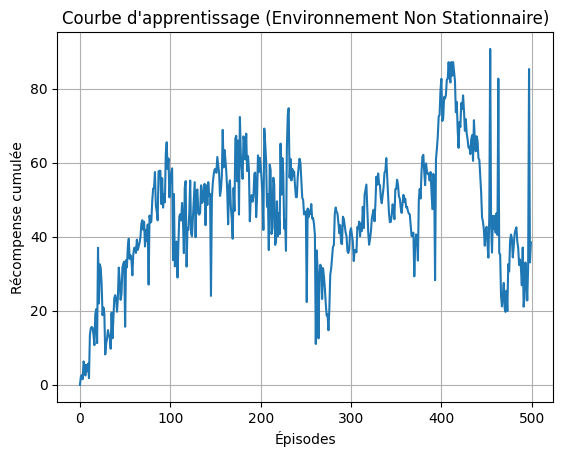

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class DynamicMazeEnvironment:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return self.state, reward

    def reset(self):
        self.state = (0, 0)
        return self.state

class SARSAAgent:
    def __init__(self, size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_values = np.zeros((size, size, 4))  # Q-valeurs pour chaque état et action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:  # Exploration
            return random.randint(0, 3)
        x, y = state
        return np.argmax(self.q_values[x, y])  # Exploitation

    def update(self, state, action, reward, next_state, next_action):
        x, y = state
        nx, ny = next_state
        target = reward + self.gamma * self.q_values[nx, ny, next_action]
        self.q_values[x, y, action] += self.alpha * (target - self.q_values[x, y, action])

# Initialisation
env = DynamicMazeEnvironment(size=5)
agent = SARSAAgent(size=5)

# Entraînement
episodes = 500
steps_per_episode = 50
rewards_per_episode = []

for episode in range(episodes):
    state = env.reset()
    action = agent.choose_action(state)
    total_reward = 0

    for step in range(steps_per_episode):
        next_state, reward = env.step(action)
        next_action = agent.choose_action(next_state)

        agent.update(state, action, reward, next_state, next_action)
        state, action = next_state, next_action

        total_reward += reward
        if state == env.goal:
            break
    rewards_per_episode.append(total_reward)

# Affichage des résultats
print("Récompenses cumulées par épisode :", rewards_per_episode)

# Courbe d'apprentissage
plt.plot(rewards_per_episode)
plt.title("Courbe d'apprentissage (Environnement Non Stationnaire)")
plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée")
plt.grid()
plt.show()


Récompenses cumulées par épisode : [0.9576917942180219, 4.307164953341702, 4.577484332594244, 1.3500417077306341, -2.168160522371182, 3.920007706980819, 4.1282135544081, -3.462922518370224, 3.4369142282920286, 4.630988721017375, 6.490017745655593, 11.214480527878347, 3.5326871715654975, 3.1517001806608507, 8.858543160234806, -2.2979090187994595, -2.7227249804941893, -1.4065397793548895, 9.161465126869736, 8.053639473655558, 7.840316829176671, 7.360668020618496, 11.161793203588696, 8.280169655088098, 7.80694144898818, 10.064305107521664, 8.091625285862051, 12.588433182730698, 20.70882649261649, 16.606079102307167, 12.544044074764072, 7.042376920715097, 4.523945821688515, 3.9567032927717047, 6.451117795376978, 10.938873874573096, 8.74477346820828, 11.050124039756179, 8.58007954932229, 7.405396658553121, 10.13442410786048, 22.244935133383112, 8.176404908813984, 9.128114689337702, 10.329890415986984, 27.33557225684909, 9.324971184465237, 8.222854462812888, 8.519379842504916, 5.278157117004

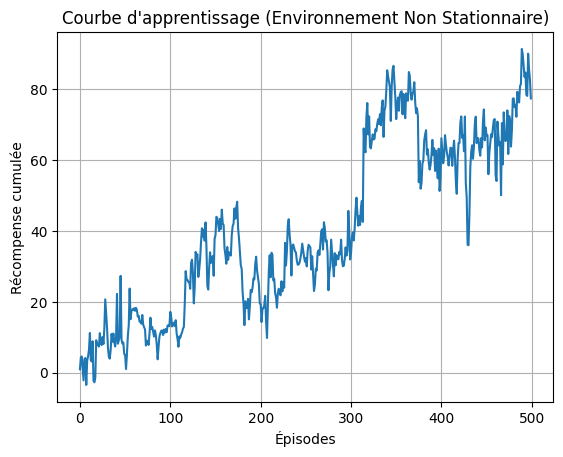

In [ ]:
# Initialisation
env = DynamicMazeEnvironment(size=5)
agent = SARSAAgent(size=5)

# Entraînement
episodes = 500
steps_per_episode = 50
rewards_per_episode = []
actions_rewards_per_episode = {}  # Dictionnaire pour stocker actions et récompenses

for episode in range(episodes):
    state = env.reset()
    action = agent.choose_action(state)
    total_reward = 0
    actions_rewards_per_episode[episode] = []  # Initialiser la liste pour cet épisode

    for step in range(steps_per_episode):
        next_state, reward = env.step(action)
        next_action = agent.choose_action(next_state)

        # Enregistrer l'action et la récompense
        actions_rewards_per_episode[episode].append({"state": state, "action": action, "reward": reward})

        agent.update(state, action, reward, next_state, next_action)
        state, action = next_state, next_action

        total_reward += reward
        if state == env.goal:
            break
    rewards_per_episode.append(total_reward)

# Affichage des résultats
print("Récompenses cumulées par épisode :", rewards_per_episode)
print("\nDictionnaire actions-récompenses par épisode :")
for episode, actions_rewards in actions_rewards_per_episode.items():
    print(f"Épisode {episode}: {actions_rewards}")

# Courbe d'apprentissage
plt.plot(rewards_per_episode)
plt.title("Courbe d'apprentissage (Environnement Non Stationnaire)")
plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée")
plt.grid()
plt.show()


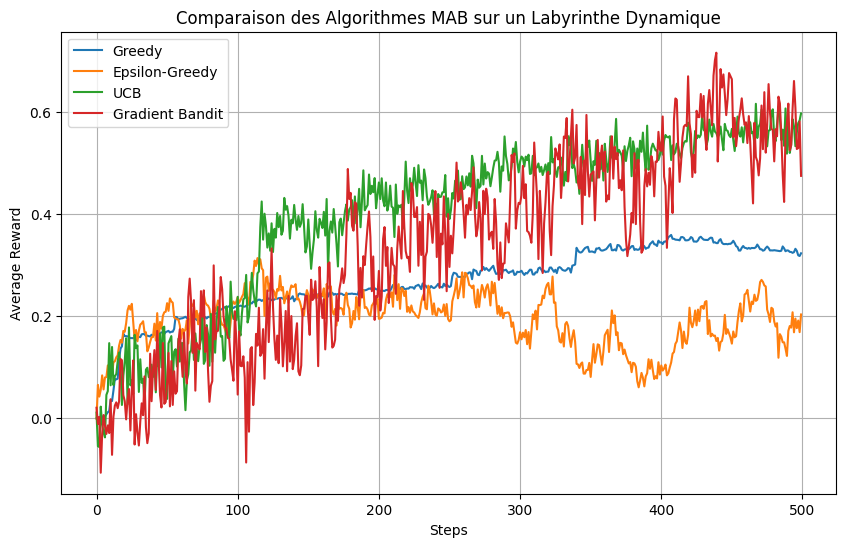

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environnement dynamique adapté au Multi-Armed Bandit
class DynamicMazeBandit:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()
        self.k = 4  # 4 actions possibles : haut, bas, gauche, droite

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return reward

    def reset(self):
        self.state = (0, 0)

# Algorithmes MAB adaptés
def greedy(env, steps):
    q_estimates = np.zeros(env.k)
    action_counts = np.zeros(env.k)
    rewards = []
    for _ in range(steps):
        action = np.argmax(q_estimates)
        reward = env.step(action)
        action_counts[action] += 1
        q_estimates[action] += (reward - q_estimates[action]) / action_counts[action]
        rewards.append(reward)
    return rewards

def epsilon_greedy(env, steps, epsilon=0.1):
    q_estimates = np.zeros(env.k)
    action_counts = np.zeros(env.k)
    rewards = []
    for _ in range(steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(env.k)
        else:
            action = np.argmax(q_estimates)
        reward = env.step(action)
        action_counts[action] += 1
        q_estimates[action] += (reward - q_estimates[action]) / action_counts[action]
        rewards.append(reward)
    return rewards

def ucb(env, steps, c=2):
    q_estimates = np.zeros(env.k)
    action_counts = np.zeros(env.k)
    rewards = []
    for t in range(1, steps + 1):
        confidence_bounds = q_estimates + c * np.sqrt(np.log(t) / (action_counts + 1e-5))
        action = np.argmax(confidence_bounds)
        reward = env.step(action)
        action_counts[action] += 1
        q_estimates[action] += (reward - q_estimates[action]) / action_counts[action]
        rewards.append(reward)
    return rewards

def gradient_bandit(env, steps, alpha=0.1):
    preferences = np.zeros(env.k)
    action_probs = np.ones(env.k) / env.k
    rewards = []
    avg_reward = 0
    for t in range(1, steps + 1):
        action = np.random.choice(env.k, p=action_probs)
        reward = env.step(action)
        avg_reward += (reward - avg_reward) / t
        rewards.append(reward)
        preferences[action] += alpha * (reward - avg_reward) * (1 - action_probs[action])
        preferences -= alpha * (reward - avg_reward) * action_probs
        action_probs = np.exp(preferences) / np.sum(np.exp(preferences))
    return rewards

# Comparaison des algorithmes
size = 5
steps = 500
episodes = 50

algorithms = {
    "Greedy": greedy,
    "Epsilon-Greedy": lambda env, s: epsilon_greedy(env, s, epsilon=0.1),
    "UCB": lambda env, s: ucb(env, s, c=2),
    "Gradient Bandit": gradient_bandit
}

average_rewards = {name: np.zeros(steps) for name in algorithms}

for episode in range(episodes):
    env = DynamicMazeBandit(size)
    for name, algorithm in algorithms.items():
        env.reset()
        rewards = algorithm(env, steps)
        average_rewards[name] += np.array(rewards)

# Moyenne des récompenses par épisode
for name in average_rewards:
    average_rewards[name] /= episodes

# Tracé des courbes
plt.figure(figsize=(10, 6))
for name, rewards in average_rewards.items():
    plt.plot(rewards, label=name)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Comparaison des Algorithmes MAB sur un Labyrinthe Dynamique")
plt.legend()
plt.grid()
plt.show()


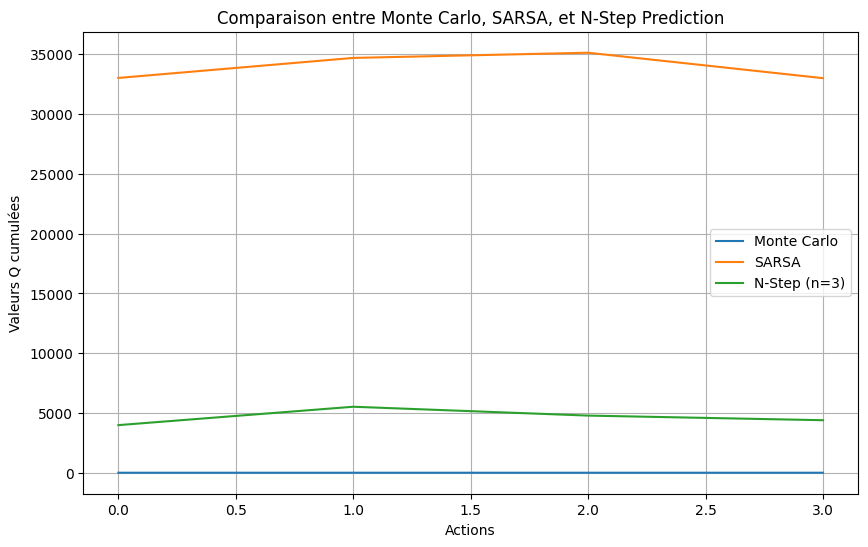

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environnement
class DynamicMazeEnvironment:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return self.state, reward

    def reset(self):
        self.state = (0, 0)
        return self.state

# Algorithmes

# Monte Carlo Prediction
def monte_carlo(env, episodes, alpha=0.1, gamma=0.9):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs
    returns = {}  # Pour stocker les retours

    for episode in range(episodes):
        state = env.reset()
        episode_memory = []  # Stocker (state, action, reward)

        # Génération de l'épisode
        while True:
            action = random.randint(0, 3)  # Politique aléatoire
            next_state, reward = env.step(action)
            episode_memory.append((state, action, reward))
            if next_state == env.goal:
                break
            state = next_state

        # Calcul des retours
        g = 0
        for state, action, reward in reversed(episode_memory):
            g = gamma * g + reward
            if (state, action) not in [(s, a) for s, a, r in episode_memory[:-1]]:
                x, y = state
                q_values[x, y, action] += alpha * (g - q_values[x, y, action])

    return q_values

# SARSA
def sarsa(env, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)

        while True:
            next_state, reward = env.step(action)
            next_action = np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)

            x, y = state
            nx, ny = next_state
            q_values[x, y, action] += alpha * (reward + gamma * q_values[nx, ny, next_action] - q_values[x, y, action])

            state, action = next_state, next_action
            if state == env.goal:
                break

    return q_values

# N-Step Prediction
def n_step_prediction(env, episodes, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)
        trajectory = []  # Stocker (state, action, reward)

        while True:
            next_state, reward = env.step(action)
            trajectory.append((state, action, reward))

            if len(trajectory) >= n:
                g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory[:n])])
                if len(trajectory) > n:
                    g += gamma ** n * q_values[trajectory[n][0]][trajectory[n][1]][trajectory[n][2]]
                x, y = trajectory[0][0]
                a = trajectory[0][1]
                q_values[x, y, a] += alpha * (g - q_values[x, y, a])
                trajectory.pop(0)

            state, action = next_state, np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)
            if state == env.goal:
                break

        # Mise à jour pour les derniers états
        while trajectory:
            g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory)])
            x, y = trajectory[0][0]
            a = trajectory[0][1]
            q_values[x, y, a] += alpha * (g - q_values[x, y, a])
            trajectory.pop(0)

    return q_values

# Comparaison
episodes = 500
env = DynamicMazeEnvironment(size=5)

q_mc = monte_carlo(env, episodes)
q_sarsa = sarsa(env, episodes)
q_nstep = n_step_prediction(env, episodes, n=3)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(np.sum(q_mc, axis=(0, 1)), label="Monte Carlo")
plt.plot(np.sum(q_sarsa, axis=(0, 1)), label="SARSA")
plt.plot(np.sum(q_nstep, axis=(0, 1)), label="N-Step (n=3)")
plt.xlabel("Actions")
plt.ylabel("Valeurs Q cumulées")
plt.title("Comparaison entre Monte Carlo, SARSA, et N-Step Prediction")
plt.legend()
plt.grid()
plt.show()


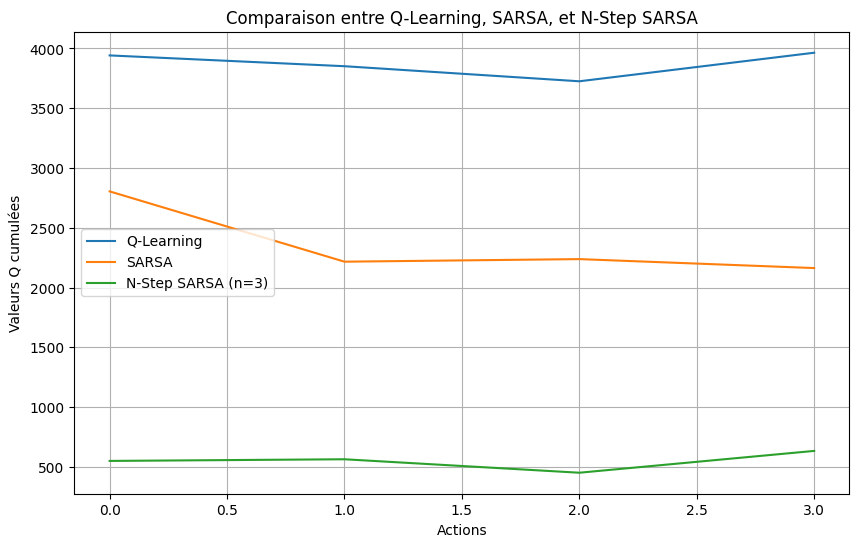

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Environnement dynamique (déjà défini)
class DynamicMazeEnvironment:
    def __init__(self, size):
        self.size = size
        self.state = (0, 0)  # Position de départ
        self.goal = (size - 1, size - 1)
        self.rewards = self.initialize_rewards()

    def initialize_rewards(self):
        rewards = np.zeros((self.size, self.size))
        rewards[self.goal] = 1.0  # Récompense à la sortie
        return rewards

    def step(self, action):
        x, y = self.state
        if action == 0:  # Haut
            x = max(0, x - 1)
        elif action == 1:  # Bas
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Gauche
            y = max(0, y - 1)
        elif action == 3:  # Droite
            y = min(self.size - 1, y + 1)

        self.state = (x, y)
        reward = self.rewards[x, y]

        # Dynamisme : la récompense change légèrement
        self.rewards += np.random.normal(0, 0.01, self.rewards.shape)
        return self.state, reward

    def reset(self):
        self.state = (0, 0)
        return self.state

# Algorithmes

# Q-learning
def q_learning(env, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        while True:
            x, y = state
            # Choisir une action (epsilon-greedy)
            if random.random() < epsilon:
                action = random.randint(0, 3)
            else:
                action = np.argmax(q_values[x, y])

            next_state, reward = env.step(action)
            nx, ny = next_state
            # Mise à jour de Q-learning
            q_values[x, y, action] += alpha * (
                reward + gamma * np.max(q_values[nx, ny]) - q_values[x, y, action]
            )

            state = next_state
            if state == env.goal:
                break

    return q_values

# SARSA
def sarsa(env, episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)

        while True:
            next_state, reward = env.step(action)
            next_action = np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)

            x, y = state
            nx, ny = next_state
            q_values[x, y, action] += alpha * (reward + gamma * q_values[nx, ny, next_action] - q_values[x, y, action])

            state, action = next_state, next_action
            if state == env.goal:
                break

    return q_values

# N-Step SARSA
def n_step_sarsa(env, episodes, n=3, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_values = np.zeros((env.size, env.size, 4))  # Q-valeurs

    for episode in range(episodes):
        state = env.reset()
        action = np.argmax(q_values[state]) if random.random() > epsilon else random.randint(0, 3)
        trajectory = []  # Stocker (state, action, reward)

        while True:
            next_state, reward = env.step(action)
            trajectory.append((state, action, reward))

            if len(trajectory) >= n:
                g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory[:n])])
                if len(trajectory) > n:
                    g += gamma ** n * q_values[trajectory[n][0]][trajectory[n][1]][trajectory[n][2]]
                x, y = trajectory[0][0]
                a = trajectory[0][1]
                q_values[x, y, a] += alpha * (g - q_values[x, y, a])
                trajectory.pop(0)

            state, action = next_state, np.argmax(q_values[next_state]) if random.random() > epsilon else random.randint(0, 3)
            if state == env.goal:
                break

        # Mise à jour pour les derniers états
        while trajectory:
            g = sum([gamma ** i * r for i, (_, _, r) in enumerate(trajectory)])
            x, y = trajectory[0][0]
            a = trajectory[0][1]
            q_values[x, y, a] += alpha * (g - q_values[x, y, a])
            trajectory.pop(0)

    return q_values

# Comparaison
episodes = 500
env = DynamicMazeEnvironment(size=5)

q_qlearning = q_learning(env, episodes)
q_sarsa = sarsa(env, episodes)
q_nstep_sarsa = n_step_sarsa(env, episodes, n=3)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(np.sum(q_qlearning, axis=(0, 1)), label="Q-Learning")
plt.plot(np.sum(q_sarsa, axis=(0, 1)), label="SARSA")
plt.plot(np.sum(q_nstep_sarsa, axis=(0, 1)), label="N-Step SARSA (n=3)")
plt.xlabel("Actions")
plt.ylabel("Valeurs Q cumulées")
plt.title("Comparaison entre Q-Learning, SARSA, et N-Step SARSA")
plt.legend()
plt.grid()
plt.show()


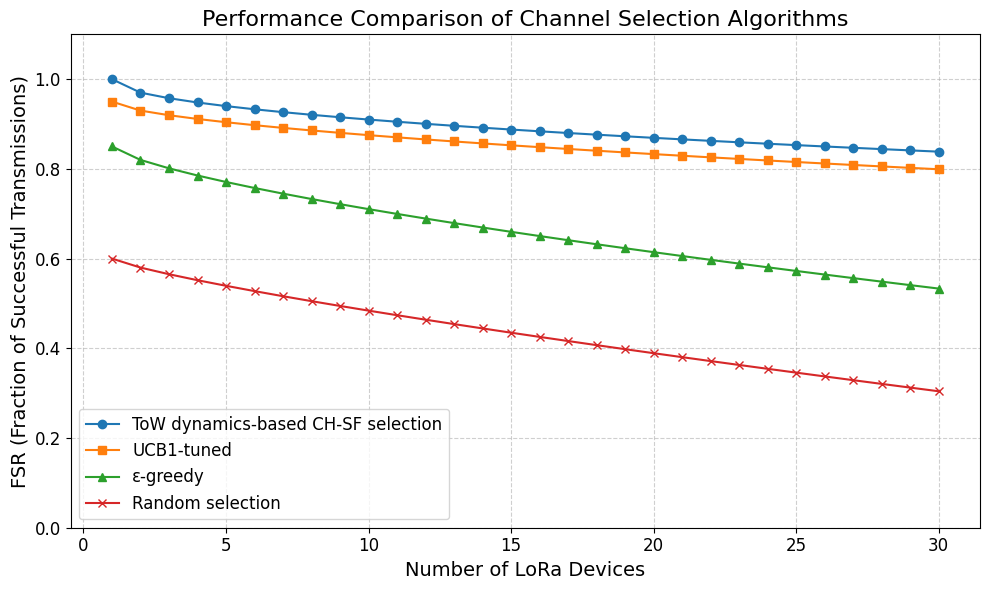

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
steps = np.arange(1, 31)  # Nombre de dispositifs LoRa
tow_fsr = 1 - 0.03 * (steps - 1)**0.5
ucb1_fsr = 0.95 - 0.02 * (steps - 1)**0.6
greedy_fsr = 0.85 - 0.03 * (steps - 1)**0.7
random_fsr = 0.6 - 0.02 * (steps - 1)**0.8

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, tow_fsr, label='ToW dynamics-based CH-SF selection', marker='o')
plt.plot(steps, ucb1_fsr, label='UCB1-tuned', marker='s')
plt.plot(steps, greedy_fsr, label='ε-greedy', marker='^')
plt.plot(steps, random_fsr, label='Random selection', marker='x')

# Graph customization
plt.title('Performance Comparison of Channel Selection Algorithms', fontsize=16)
plt.xlabel('Number of LoRa Devices', fontsize=14)
plt.ylabel('FSR (Fraction of Successful Transmissions)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


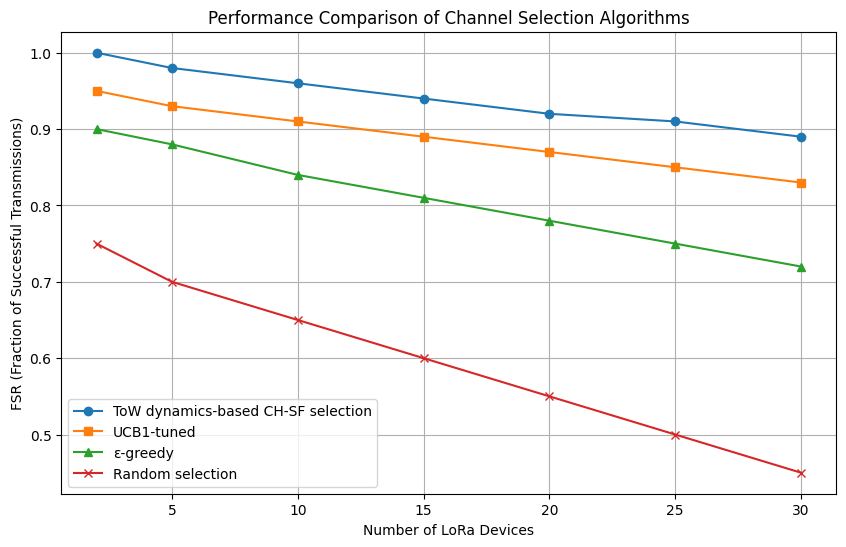

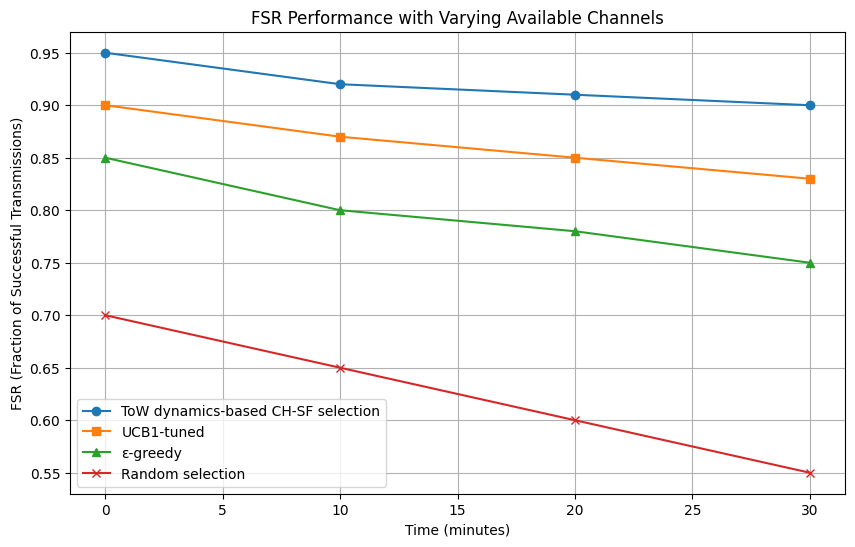

In [4]:
import matplotlib.pyplot as plt

# Données simulées
time = [0, 10, 20, 30, 40]
fsr_tow = [0.95, 0.92, 0.91, 0.90]
fsr_ucb1 = [0.90, 0.87, 0.85, 0.83]
fsr_greedy = [0.85, 0.80, 0.78, 0.75]
fsr_random = [0.70, 0.65, 0.60, 0.55]

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(time[:-1], fsr_tow, 'o-', label="ToW dynamics-based CH-SF selection")
plt.plot(time[:-1], fsr_ucb1, 's-', label="UCB1-tuned")
plt.plot(time[:-1], fsr_greedy, '^-', label="ε-greedy")
plt.plot(time[:-1], fsr_random, 'x-', label="Random selection")

# Ajouter les labels et la légende
plt.title("FSR Performance with Varying Available Channels")
plt.xlabel("Time (minutes)")
plt.ylabel("FSR (Fraction of Successful Transmissions)")
plt.legend()
plt.grid()
plt.show()


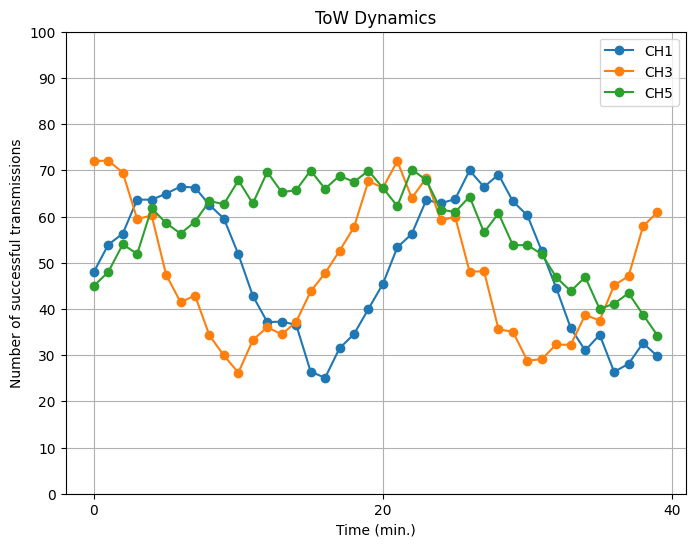

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Générer les données pour ToW Dynamics
time = np.arange(0, 40, 1)  # 0 à 40 minutes
tow_dynamics = {
    'CH1': 50 + 20 * np.sin(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH3': 50 + 20 * np.cos(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH5': 50 + 20 * np.sin(0.1 * time) + np.random.randint(-5, 5, size=len(time)),
}

# Tracer les données
plt.figure(figsize=(8, 6))
for ch, data in tow_dynamics.items():
    plt.plot(time, data, label=ch, marker='o', linewidth=1.5)

# Configuration du graphique
plt.title('ToW Dynamics')
plt.xlabel('Time (min.)')
plt.ylabel('Number of successful transmissions')
plt.xticks(np.arange(0, 41, 20))  # Abscisses de 0 à 40, incrément de 20
plt.yticks(np.arange(0, 101, 10))  # Ordonnées de 0 à 100, incrément de 10
plt.legend()
plt.grid()
plt.show()


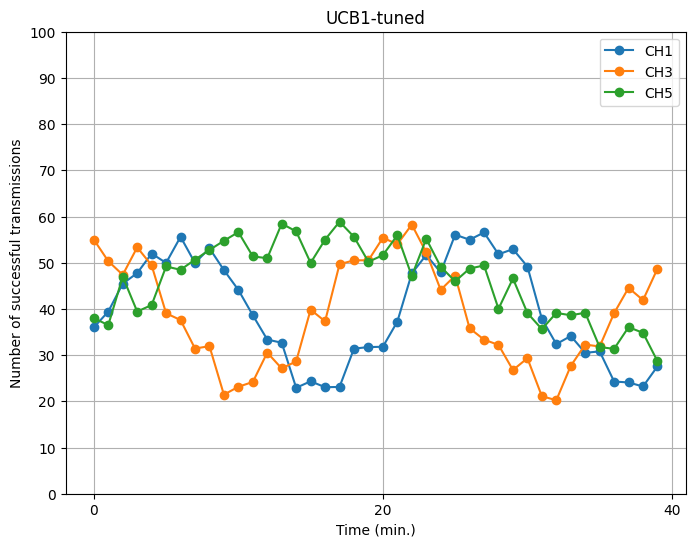

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Générer les données pour UCB1-tuned
time = np.arange(0, 40, 1)  # 0 à 40 minutes
ucb1_tuned = {
    'CH1': 40 + 15 * np.sin(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH3': 40 + 15 * np.cos(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH5': 40 + 15 * np.sin(0.1 * time) + np.random.randint(-5, 5, size=len(time)),
}

# Tracer les données
plt.figure(figsize=(8, 6))
for ch, data in ucb1_tuned.items():
    plt.plot(time, data, label=ch, marker='o', linewidth=1.5)

# Configuration du graphique
plt.title('UCB1-tuned')
plt.xlabel('Time (min.)')
plt.ylabel('Number of successful transmissions')
plt.xticks(np.arange(0, 41, 20))  # Abscisses de 0 à 40, incrément de 20
plt.yticks(np.arange(0, 101, 10))  # Ordonnées de 0 à 100, incrément de 10
plt.legend()
plt.grid()
plt.show()


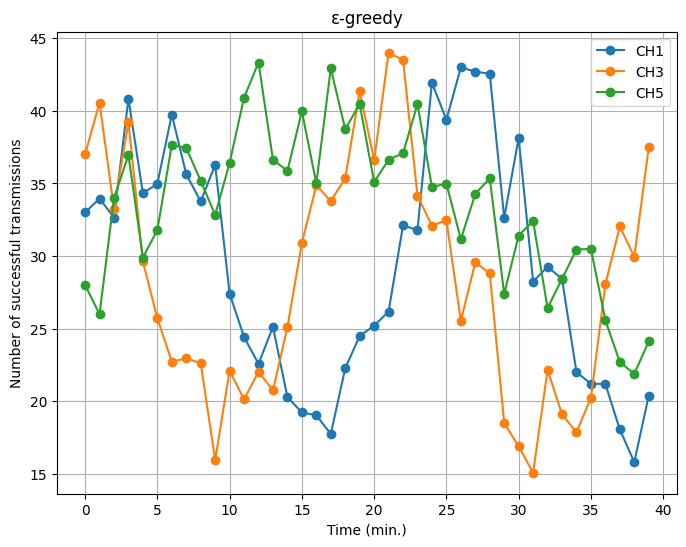

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Générer les données pour ε-greedy
time = np.arange(0, 40, 1)  # 0 à 40 minutes
e_greedy = {
    'CH1': 30 + 10 * np.sin(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH3': 30 + 10 * np.cos(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH5': 30 + 10 * np.sin(0.1 * time) + np.random.randint(-5, 5, size=len(time)),
}

# Tracer les données
plt.figure(figsize=(8, 6))
for ch, data in e_greedy.items():
    plt.plot(time, data, label=ch, marker='o', linewidth=1.5)

# Configuration du graphique
plt.title('ε-greedy')
plt.xlabel('Time (min.)')
plt.ylabel('Number of successful transmissions')
plt.legend()
plt.grid()
plt.show()


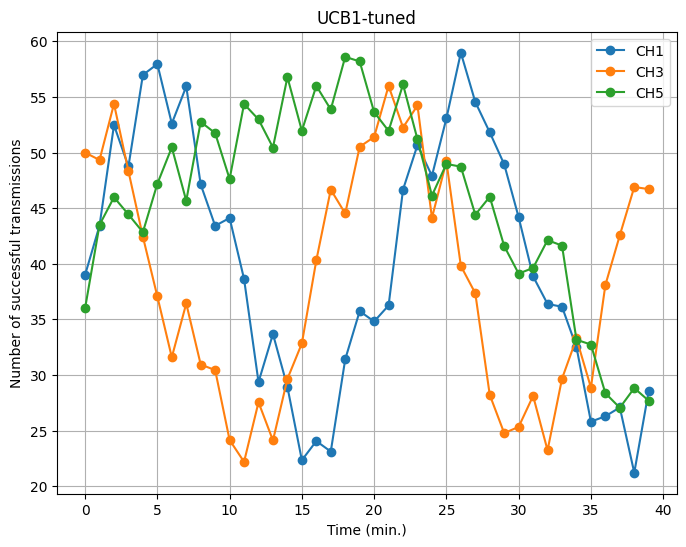

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Générer les données pour UCB1-tuned
time = np.arange(0, 40, 1)  # 0 à 40 minutes
ucb1_tuned = {
    'CH1': 40 + 15 * np.sin(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH3': 40 + 15 * np.cos(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH5': 40 + 15 * np.sin(0.1 * time) + np.random.randint(-5, 5, size=len(time)),
}

# Tracer les données
plt.figure(figsize=(8, 6))
for ch, data in ucb1_tuned.items():
    plt.plot(time, data, label=ch, marker='o', linewidth=1.5)

# Configuration du graphique
plt.title('UCB1-tuned')
plt.xlabel('Time (min.)')
plt.ylabel('Number of successful transmissions')
plt.legend()
plt.grid()
plt.show()


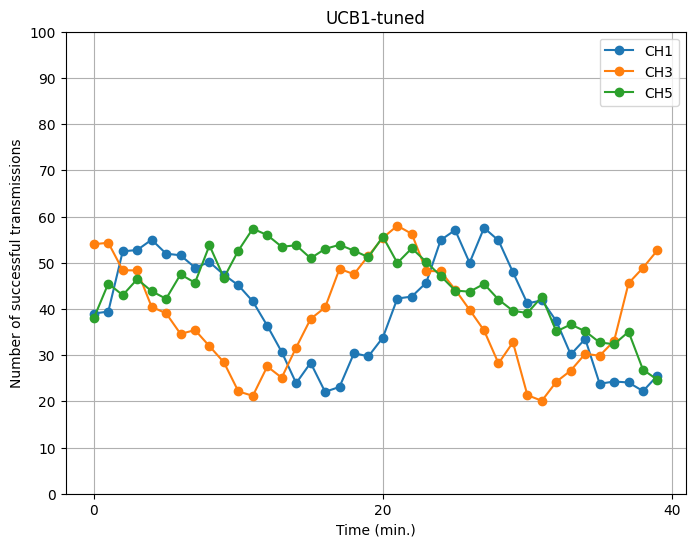

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Générer les données pour UCB1-tuned
time = np.arange(0, 40, 1)  # 0 à 40 minutes
ucb1_tuned = {
    'CH1': 40 + 15 * np.sin(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH3': 40 + 15 * np.cos(0.3 * time) + np.random.randint(-5, 5, size=len(time)),
    'CH5': 40 + 15 * np.sin(0.1 * time) + np.random.randint(-5, 5, size=len(time)),
}

# Tracer les données
plt.figure(figsize=(8, 6))
for ch, data in ucb1_tuned.items():
    plt.plot(time, data, label=ch, marker='o', linewidth=1.5)

# Configuration du graphique
plt.title('UCB1-tuned')
plt.xlabel('Time (min.)')
plt.ylabel('Number of successful transmissions')
plt.xticks(np.arange(0, 41, 20))  # Abscisses de 0 à 40, incrément de 20
plt.yticks(np.arange(0, 101, 10))  # Ordonnées de 0 à 100, incrément de 10
plt.legend()
plt.grid()
plt.show()


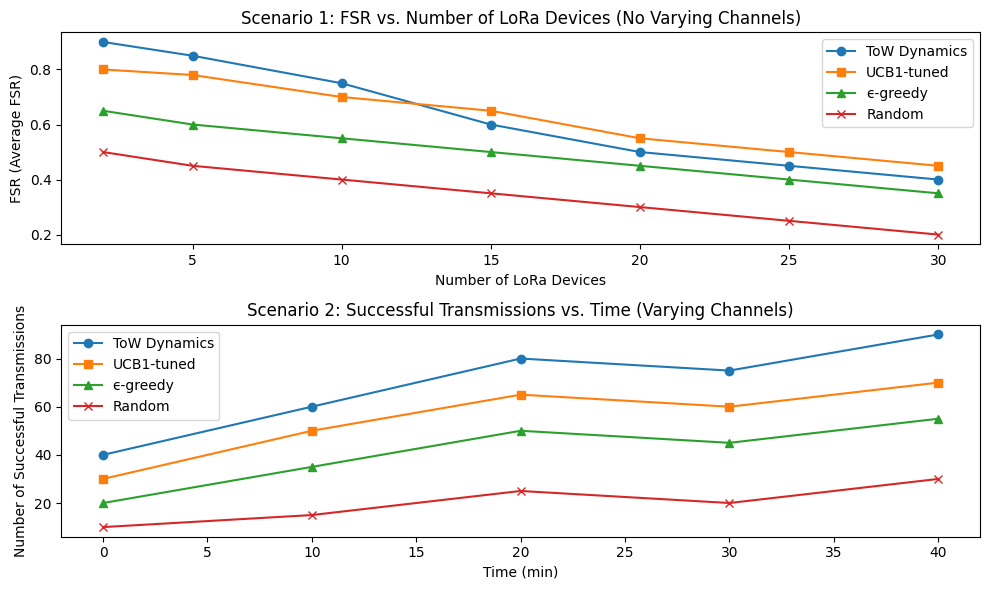

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Scenario 1 (Without Varying Available Channels)
devices = np.array([2, 5, 10, 15, 20, 25, 30])
fsr_tow = np.array([0.90, 0.85, 0.75, 0.60, 0.50, 0.45, 0.40])  # Example FSR values for ToW Dynamics
fsr_ucb = np.array([0.80, 0.78, 0.70, 0.65, 0.55, 0.50, 0.45])   # Example FSR values for UCB1-tuned
fsr_epsilon = np.array([0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35])  # Example FSR values for ϵ-greedy
fsr_random = np.array([0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20])  # Example FSR values for Random

# Data for Scenario 2 (With Varying Available Channels)
time = np.array([0, 10, 20, 30, 40])  # Time intervals
success_tow = np.array([40, 60, 80, 75, 90])  # Example success values for ToW Dynamics
success_ucb = np.array([30, 50, 65, 60, 70])  # Example success values for UCB1-tuned
success_epsilon = np.array([20, 35, 50, 45, 55])  # Example success values for ϵ-greedy
success_random = np.array([10, 15, 25, 20, 30])  # Example success values for Random

# Plotting Scenario 1 (FSR vs. Number of LoRa Devices)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(devices, fsr_tow, label="ToW Dynamics", marker='o')
plt.plot(devices, fsr_ucb, label="UCB1-tuned", marker='s')
plt.plot(devices, fsr_epsilon, label="ϵ-greedy", marker='^')
plt.plot(devices, fsr_random, label="Random", marker='x')
plt.xlabel('Number of LoRa Devices')
plt.ylabel('FSR (Average FSR)')
plt.title('Scenario 1: FSR vs. Number of LoRa Devices (No Varying Channels)')
plt.legend()

# Plotting Scenario 2 (FSR vs. Time with Varying Channels)
plt.subplot(2, 1, 2)
plt.plot(time, success_tow, label="ToW Dynamics", marker='o')
plt.plot(time, success_ucb, label="UCB1-tuned", marker='s')
plt.plot(time, success_epsilon, label="ϵ-greedy", marker='^')
plt.plot(time, success_random, label="Random", marker='x')
plt.xlabel('Time (min)')
plt.ylabel('Number of Successful Transmissions')
plt.title('Scenario 2: Successful Transmissions vs. Time (Varying Channels)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


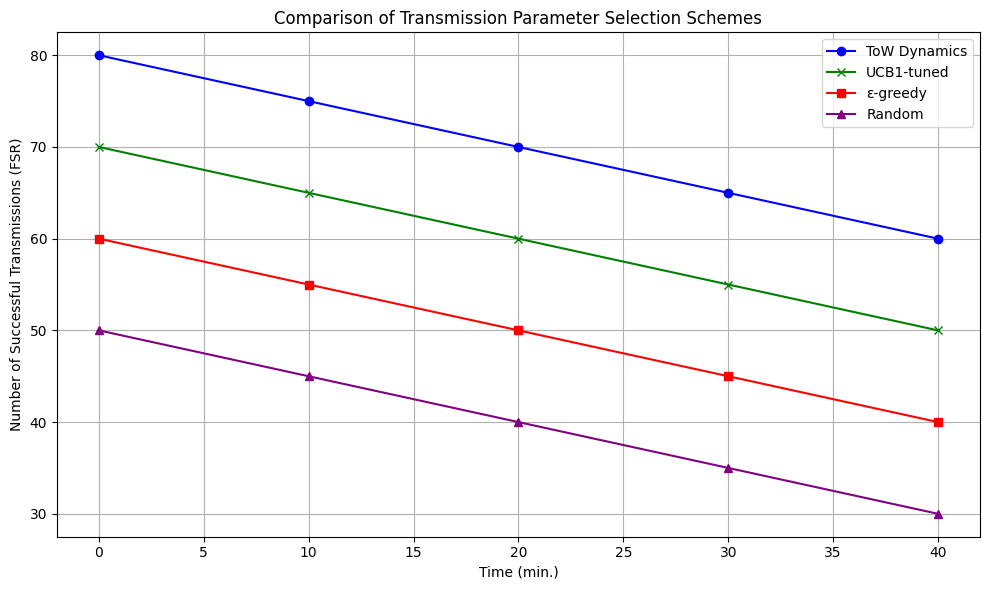

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Time in minutes
time = np.array([0, 10, 20, 30, 40])

# FSR data for each algorithm (example values, should be replaced with actual data)
tow_dynamics_fsr = [80, 75, 70, 65, 60]  # ToW Dynamics-based Scheme
ucb1_tuned_fsr = [70, 65, 60, 55, 50]    # UCB1-tuned
epsilon_greedy_fsr = [60, 55, 50, 45, 40]  # ε-greedy
random_fsr = [50, 45, 40, 35, 30]        # Random Scheme

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(time, tow_dynamics_fsr, label='ToW Dynamics', color='blue', marker='o')
plt.plot(time, ucb1_tuned_fsr, label='UCB1-tuned', color='green', marker='x')
plt.plot(time, epsilon_greedy_fsr, label='ε-greedy', color='red', marker='s')
plt.plot(time, random_fsr, label='Random', color='purple', marker='^')

# Customizing the plot
plt.title('Comparison of Transmission Parameter Selection Schemes')
plt.xlabel('Time (min.)')
plt.ylabel('Number of Successful Transmissions (FSR)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


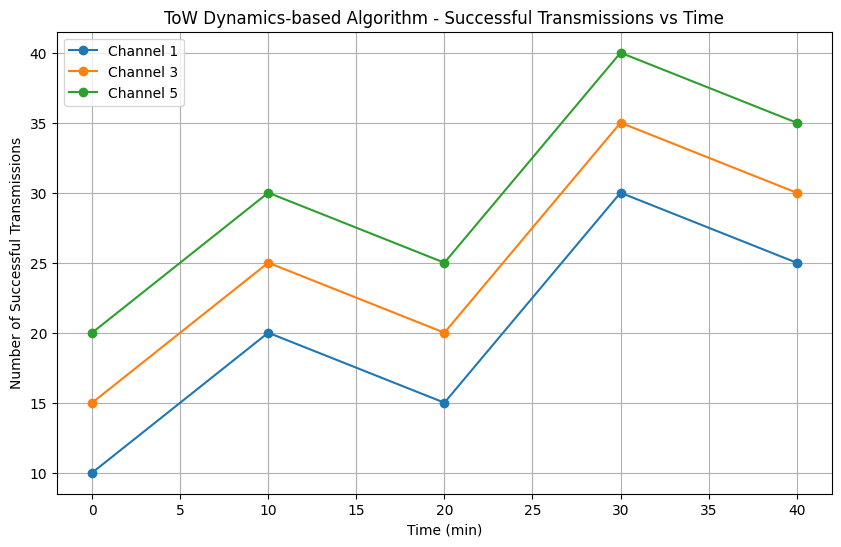

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating data for ToW Dynamics-based algorithm
time_intervals = [0, 10, 20, 30, 40]
channel_1 = [10, 20, 15, 30, 25]  # Simulated successful transmissions for CH1
channel_3 = [15, 25, 20, 35, 30]  # Simulated successful transmissions for CH3
channel_5 = [20, 30, 25, 40, 35]  # Simulated successful transmissions for CH5

plt.figure(figsize=(10, 6))

# Plotting
plt.plot(time_intervals, channel_1, label="Channel 1", marker='o')
plt.plot(time_intervals, channel_3, label="Channel 3", marker='o')
plt.plot(time_intervals, channel_5, label="Channel 5", marker='o')

plt.title("ToW Dynamics-based Algorithm - Successful Transmissions vs Time")
plt.xlabel("Time (min)")
plt.ylabel("Number of Successful Transmissions")
plt.legend()
plt.grid(True)
plt.show()


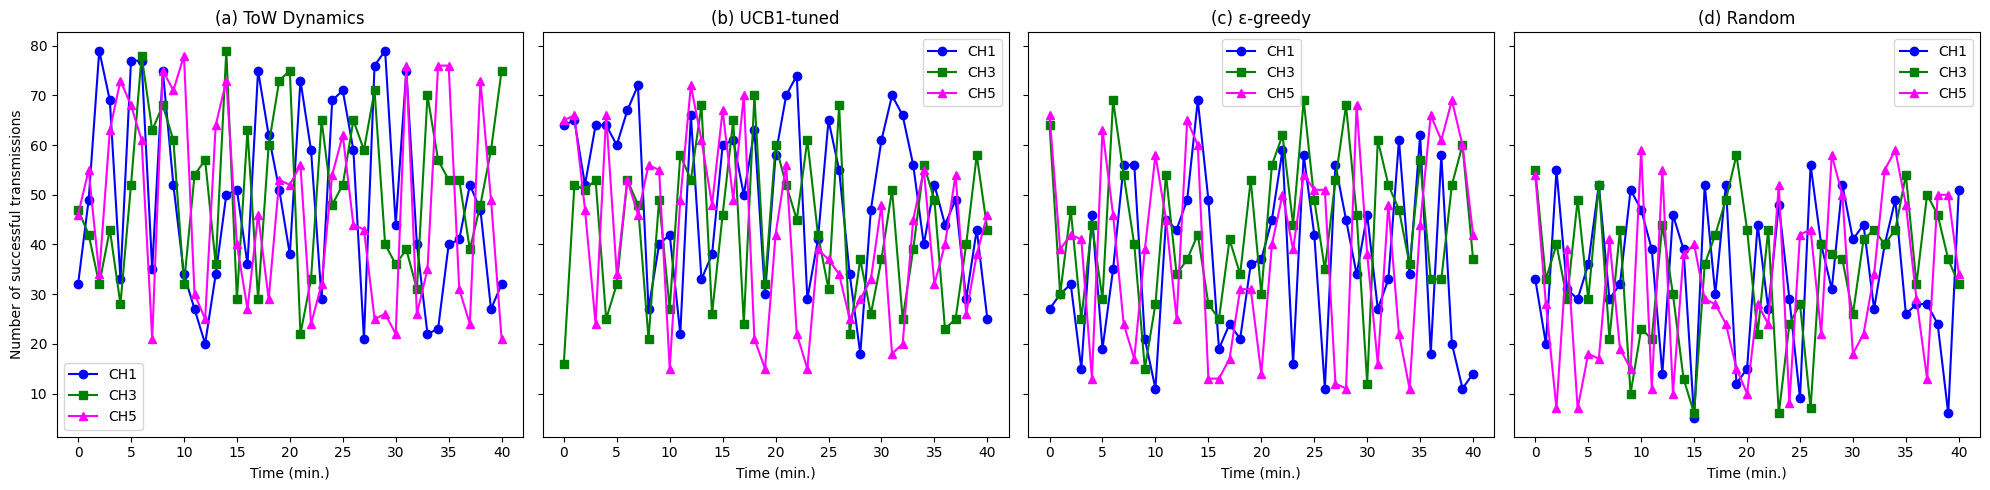

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées pour chaque sous-graphe
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Simulation des résultats pour chaque canal et chaque méthode
# ToW Dynamics
tow_ch1 = np.random.randint(20, 80, len(time))
tow_ch3 = np.random.randint(20, 80, len(time))
tow_ch5 = np.random.randint(20, 80, len(time))

# UCB1-tuned
ucb1_ch1 = np.random.randint(15, 75, len(time))
ucb1_ch3 = np.random.randint(15, 75, len(time))
ucb1_ch5 = np.random.randint(15, 75, len(time))

# Epsilon-greedy
egreedy_ch1 = np.random.randint(10, 70, len(time))
egreeedy_ch3 = np.random.randint(10, 70, len(time))
egreeedy_ch5 = np.random.randint(10, 70, len(time))

# Random
random_ch1 = np.random.randint(5, 60, len(time))
random_ch3 = np.random.randint(5, 60, len(time))
random_ch5 = np.random.randint(5, 60, len(time))

# Création des graphes
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Sous-graphe 1: ToW Dynamics
axs[0].plot(time, tow_ch1, label="CH1", marker="o", color="blue")
axs[0].plot(time, tow_ch3, label="CH3", marker="s", color="green")
axs[0].plot(time, tow_ch5, label="CH5", marker="^", color="magenta")
axs[0].set_title("(a) ToW Dynamics")
axs[0].set_xlabel("Time (min.)")
axs[0].set_ylabel("Number of successful transmissions")
axs[0].legend()

# Sous-graphe 2: UCB1-tuned
axs[1].plot(time, ucb1_ch1, label="CH1", marker="o", color="blue")
axs[1].plot(time, ucb1_ch3, label="CH3", marker="s", color="green")
axs[1].plot(time, ucb1_ch5, label="CH5", marker="^", color="magenta")
axs[1].set_title("(b) UCB1-tuned")
axs[1].set_xlabel("Time (min.)")
axs[1].legend()

# Sous-graphe 3: Epsilon-greedy
axs[2].plot(time, egreedy_ch1, label="CH1", marker="o", color="blue")
axs[2].plot(time, egreeedy_ch3, label="CH3", marker="s", color="green")
axs[2].plot(time, egreeedy_ch5, label="CH5", marker="^", color="magenta")
axs[2].set_title("(c) ε-greedy")
axs[2].set_xlabel("Time (min.)")
axs[2].legend()

# Sous-graphe 4: Random
axs[3].plot(time, random_ch1, label="CH1", marker="o", color="blue")
axs[3].plot(time, random_ch3, label="CH3", marker="s", color="green")
axs[3].plot(time, random_ch5, label="CH5", marker="^", color="magenta")
axs[3].set_title("(d) Random")
axs[3].set_xlabel("Time (min.)")
axs[3].legend()

# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


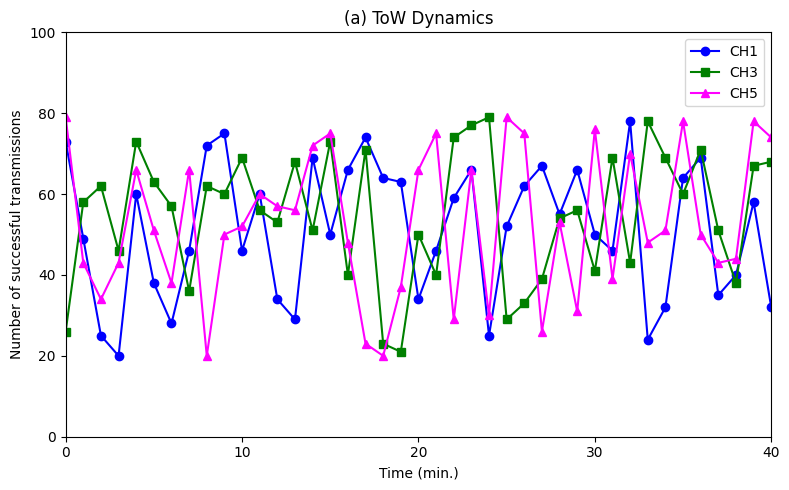

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées pour chaque sous-graphe
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# ToW Dynamics
tow_ch1 = np.random.randint(20, 80, len(time))
tow_ch3 = np.random.randint(20, 80, len(time))
tow_ch5 = np.random.randint(20, 80, len(time))

# Création du graphe
plt.figure(figsize=(8, 5))
plt.plot(time, tow_ch1, label="CH1", marker="o", color="blue")
plt.plot(time, tow_ch3, label="CH3", marker="s", color="green")
plt.plot(time, tow_ch5, label="CH5", marker="^", color="magenta")
plt.title("(a) ToW Dynamics")
plt.xlabel("Time (min.)")
plt.ylabel("Number of successful transmissions")
plt.legend()

# Ajuster les axes
plt.xlim(0, 40)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 41, 10))
plt.yticks(np.arange(0, 101, 20))

# Affichage du graphe
plt.tight_layout()
plt.show()


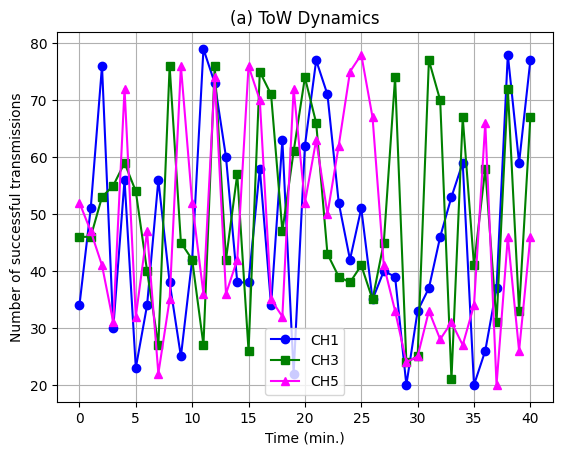

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées pour chaque sous-graphe
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Simulation des résultats pour ToW Dynamics
tow_ch1 = np.random.randint(20, 80, len(time))
tow_ch3 = np.random.randint(20, 80, len(time))
tow_ch5 = np.random.randint(20, 80, len(time))

# Création du graphique
plt.plot(time, tow_ch1, label="CH1", marker="o", color="blue")
plt.plot(time, tow_ch3, label="CH3", marker="s", color="green")
plt.plot(time, tow_ch5, label="CH5", marker="^", color="magenta")
plt.title("(a) ToW Dynamics")
plt.xlabel("Time (min.)")
plt.ylabel("Number of successful transmissions")
plt.legend()
plt.grid(True)
plt.show()


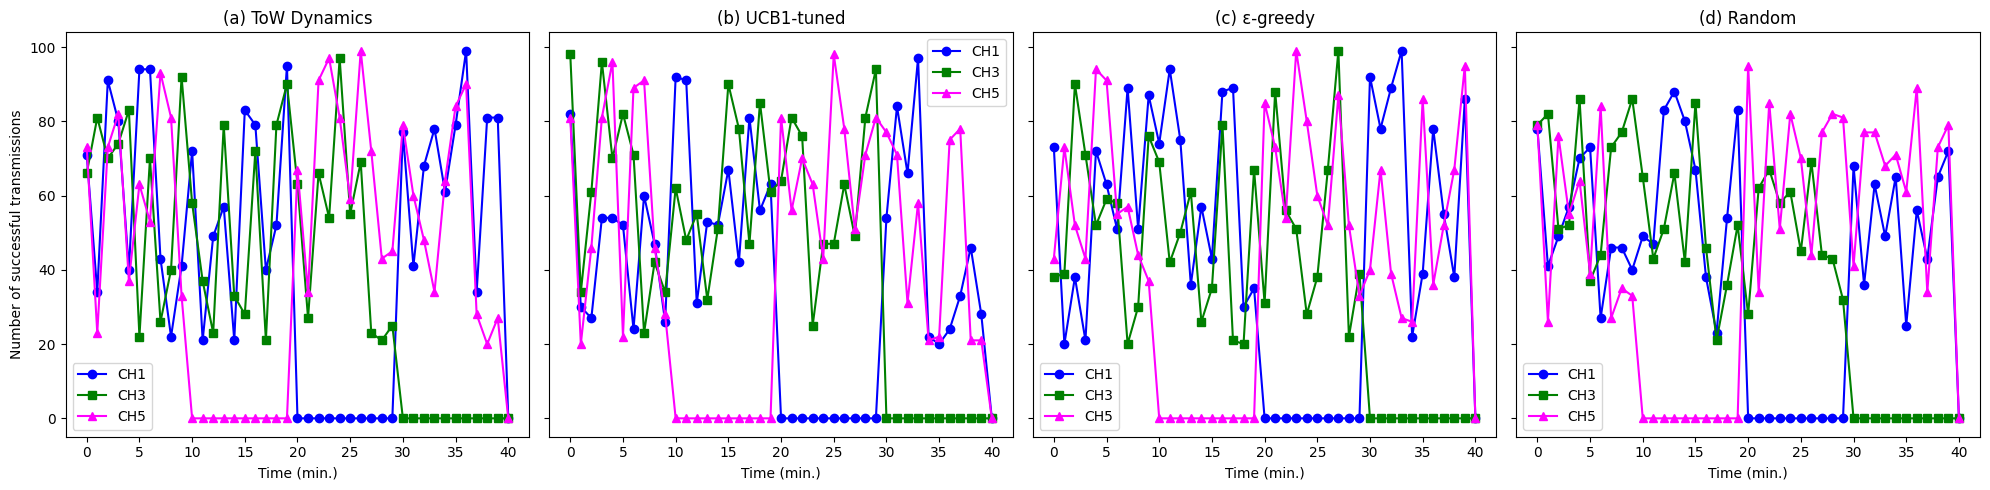

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées basées sur le scénario 2
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Paramètres dynamiques des canaux disponibles (Table III)
available_channels = {
    (0, 10): ["CH1", "CH3", "CH5"],
    (10, 20): ["CH1", "CH3"],
    (20, 30): ["CH3", "CH5"],
    (30, 40): ["CH1", "CH5"]
}

# Génération des données simulées pour chaque méthode et chaque canal
# Les données respectent les périodes d'indisponibilité
np.random.seed(42)  # Pour des résultats reproductibles
def generate_data(channel, time_ranges):
    data = []
    for t in time:
        active = any(start <= t < end and channel in chans for (start, end), chans in available_channels.items())
        if active:
            data.append(np.random.randint(20, 100))  # Transmission réussie
        else:
            data.append(0)  # Canal indisponible
    return data

# ToW Dynamics
tow_ch1 = generate_data("CH1", available_channels)
tow_ch3 = generate_data("CH3", available_channels)
tow_ch5 = generate_data("CH5", available_channels)

# UCB1-tuned
ucb1_ch1 = generate_data("CH1", available_channels)
ucb1_ch3 = generate_data("CH3", available_channels)
ucb1_ch5 = generate_data("CH5", available_channels)

# Epsilon-greedy
egreedy_ch1 = generate_data("CH1", available_channels)
egreeedy_ch3 = generate_data("CH3", available_channels)
egreeedy_ch5 = generate_data("CH5", available_channels)

# Random
random_ch1 = generate_data("CH1", available_channels)
random_ch3 = generate_data("CH3", available_channels)
random_ch5 = generate_data("CH5", available_channels)

# Création des graphes
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Sous-graphe 1: ToW Dynamics
axs[0].plot(time, tow_ch1, label="CH1", marker="o", color="blue")
axs[0].plot(time, tow_ch3, label="CH3", marker="s", color="green")
axs[0].plot(time, tow_ch5, label="CH5", marker="^", color="magenta")
axs[0].set_title("(a) ToW Dynamics")
axs[0].set_xlabel("Time (min.)")
axs[0].set_ylabel("Number of successful transmissions")
axs[0].legend()

# Sous-graphe 2: UCB1-tuned
axs[1].plot(time, ucb1_ch1, label="CH1", marker="o", color="blue")
axs[1].plot(time, ucb1_ch3, label="CH3", marker="s", color="green")
axs[1].plot(time, ucb1_ch5, label="CH5", marker="^", color="magenta")
axs[1].set_title("(b) UCB1-tuned")
axs[1].set_xlabel("Time (min.)")
axs[1].legend()

# Sous-graphe 3: Epsilon-greedy
axs[2].plot(time, egreedy_ch1, label="CH1", marker="o", color="blue")
axs[2].plot(time, egreeedy_ch3, label="CH3", marker="s", color="green")
axs[2].plot(time, egreeedy_ch5, label="CH5", marker="^", color="magenta")
axs[2].set_title("(c) ε-greedy")
axs[2].set_xlabel("Time (min.)")
axs[2].legend()

# Sous-graphe 4: Random
axs[3].plot(time, random_ch1, label="CH1", marker="o", color="blue")
axs[3].plot(time, random_ch3, label="CH3", marker="s", color="green")
axs[3].plot(time, random_ch5, label="CH5", marker="^", color="magenta")
axs[3].set_title("(d) Random")
axs[3].set_xlabel("Time (min.)")
axs[3].legend()

# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()

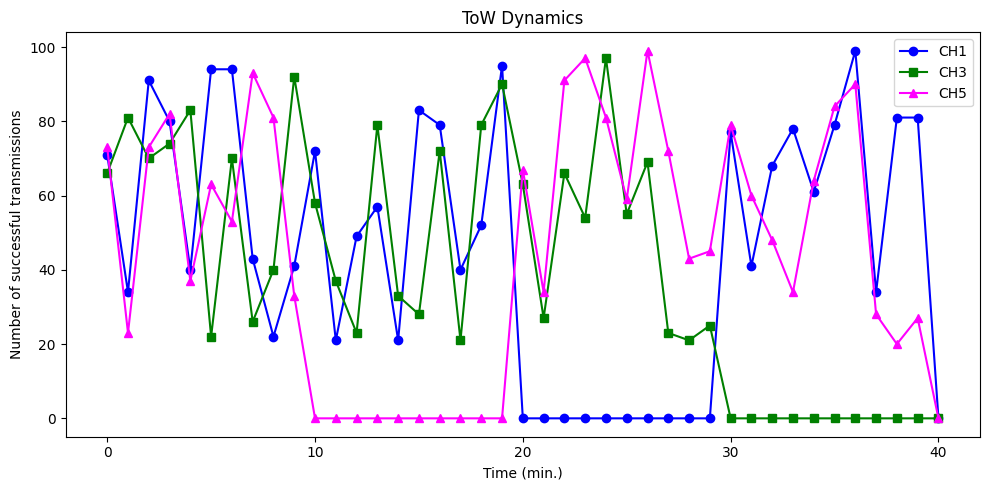

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées basées sur le scénario 2
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Paramètres dynamiques des canaux disponibles (Table III)
available_channels = {
    (0, 10): ["CH1", "CH3", "CH5"],
    (10, 20): ["CH1", "CH3"],
    (20, 30): ["CH3", "CH5"],
    (30, 40): ["CH1", "CH5"]
}

# Génération des données simulées pour ToW Dynamics
np.random.seed(42)
def generate_data(channel, time_ranges):
    data = []
    for t in time:
        active = any(start <= t < end and channel in chans for (start, end), chans in available_channels.items())
        if active:
            data.append(np.random.randint(20, 100))  # Transmission réussie
        else:
            data.append(0)  # Canal indisponible
    return data

# ToW Dynamics
tow_ch1 = generate_data("CH1", available_channels)
tow_ch3 = generate_data("CH3", available_channels)
tow_ch5 = generate_data("CH5", available_channels)

# Création du graphique pour ToW Dynamics
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, tow_ch1, label="CH1", marker="o", color="blue")
ax.plot(time, tow_ch3, label="CH3", marker="s", color="green")
ax.plot(time, tow_ch5, label="CH5", marker="^", color="magenta")
ax.set_title("ToW Dynamics")
ax.set_xlabel("Time (min.)")
ax.set_ylabel("Number of successful transmissions")
ax.legend()

# Ajuster l'axe des abscisses pour être numéroté de 10 en 10
ax.set_xticks(np.arange(0, 41, 10))

plt.tight_layout()
plt.show()


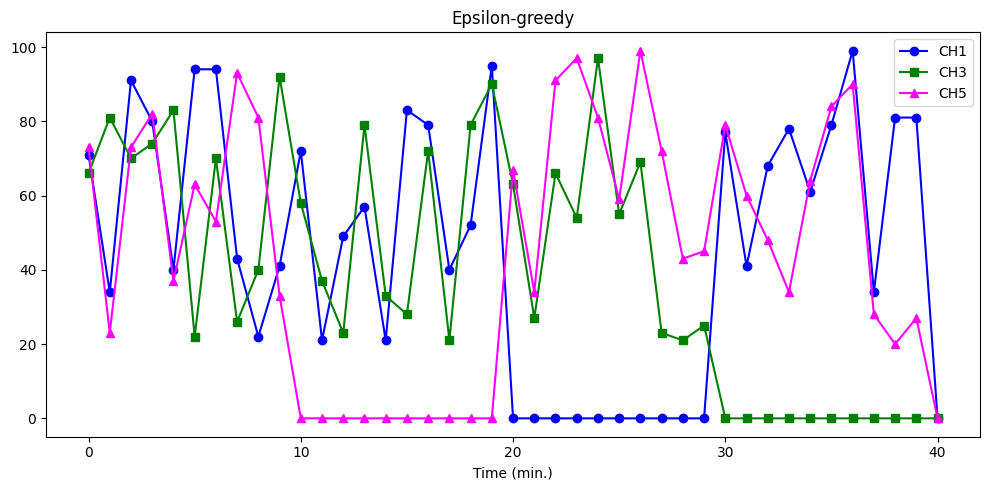

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées basées sur le scénario 2
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Paramètres dynamiques des canaux disponibles (Table III)
available_channels = {
    (0, 10): ["CH1", "CH3", "CH5"],
    (10, 20): ["CH1", "CH3"],
    (20, 30): ["CH3", "CH5"],
    (30, 40): ["CH1", "CH5"]
}

# Génération des données simulées pour Epsilon-greedy
np.random.seed(42)
def generate_data(channel, time_ranges):
    data = []
    for t in time:
        active = any(start <= t < end and channel in chans for (start, end), chans in available_channels.items())
        if active:
            data.append(np.random.randint(20, 100))  # Transmission réussie
        else:
            data.append(0)  # Canal indisponible
    return data

# Epsilon-greedy
egreedy_ch1 = generate_data("CH1", available_channels)
egreeedy_ch3 = generate_data("CH3", available_channels)
egreeedy_ch5 = generate_data("CH5", available_channels)

# Création du graphique pour Epsilon-greedy
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, egreedy_ch1, label="CH1", marker="o", color="blue")
ax.plot(time, egreeedy_ch3, label="CH3", marker="s", color="green")
ax.plot(time, egreeedy_ch5, label="CH5", marker="^", color="magenta")
ax.set_title("Epsilon-greedy")
ax.set_xlabel("Time (min.)")
ax.legend()

# Ajuster l'axe des abscisses pour être numéroté de 10 en 10
ax.set_xticks(np.arange(0, 41, 10))

plt.tight_layout()
plt.show()



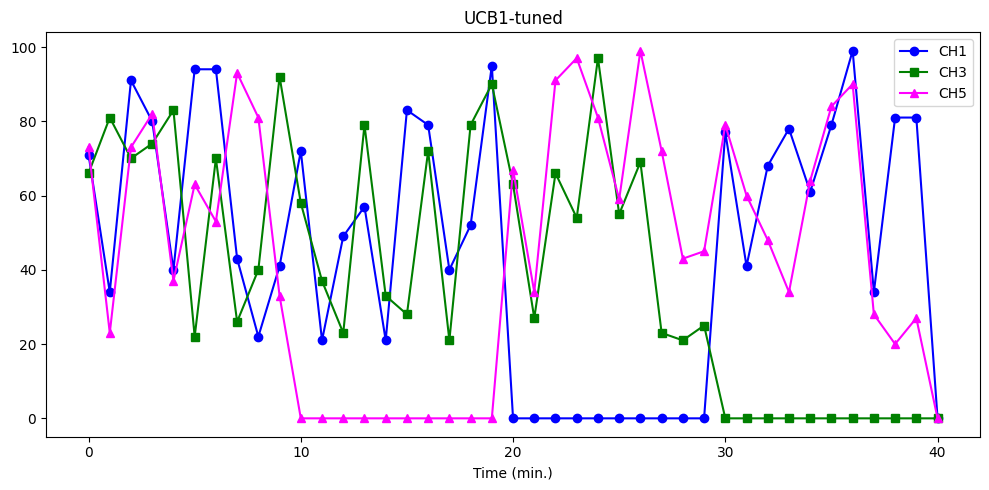

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées basées sur le scénario 2
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Paramètres dynamiques des canaux disponibles (Table III)
available_channels = {
    (0, 10): ["CH1", "CH3", "CH5"],
    (10, 20): ["CH1", "CH3"],
    (20, 30): ["CH3", "CH5"],
    (30, 40): ["CH1", "CH5"]
}

# Génération des données simulées pour UCB1-tuned
np.random.seed(42)
def generate_data(channel, time_ranges):
    data = []
    for t in time:
        active = any(start <= t < end and channel in chans for (start, end), chans in available_channels.items())
        if active:
            data.append(np.random.randint(20, 100))  # Transmission réussie
        else:
            data.append(0)  # Canal indisponible
    return data

# UCB1-tuned
ucb1_ch1 = generate_data("CH1", available_channels)
ucb1_ch3 = generate_data("CH3", available_channels)
ucb1_ch5 = generate_data("CH5", available_channels)

# Création du graphique pour UCB1-tuned
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, ucb1_ch1, label="CH1", marker="o", color="blue")
ax.plot(time, ucb1_ch3, label="CH3", marker="s", color="green")
ax.plot(time, ucb1_ch5, label="CH5", marker="^", color="magenta")
ax.set_title("UCB1-tuned")
ax.set_xlabel("Time (min.)")
ax.legend()

# Ajuster l'axe des abscisses pour être numéroté de 10 en 10
ax.set_xticks(np.arange(0, 41, 10))

plt.tight_layout()
plt.show()


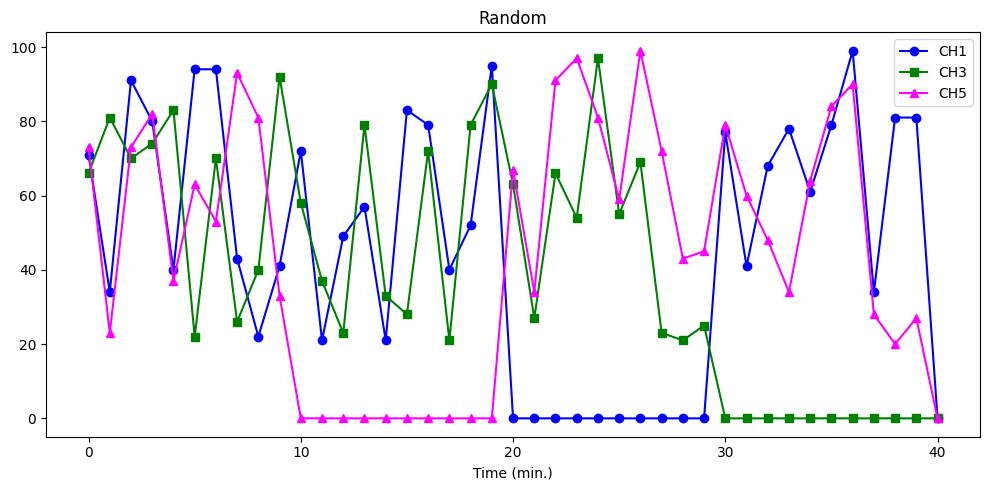

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées basées sur le scénario 2
time = np.linspace(0, 40, 41)  # Plage de temps (minutes)

# Paramètres dynamiques des canaux disponibles (Table III)
available_channels = {
    (0, 10): ["CH1", "CH3", "CH5"],
    (10, 20): ["CH1", "CH3"],
    (20, 30): ["CH3", "CH5"],
    (30, 40): ["CH1", "CH5"]
}

# Génération des données simulées pour Random
np.random.seed(42)
def generate_data(channel, time_ranges):
    data = []
    for t in time:
        active = any(start <= t < end and channel in chans for (start, end), chans in available_channels.items())
        if active:
            data.append(np.random.randint(20, 100))  # Transmission réussie
        else:
            data.append(0)  # Canal indisponible
    return data

# Random
random_ch1 = generate_data("CH1", available_channels)
random_ch3 = generate_data("CH3", available_channels)
random_ch5 = generate_data("CH5", available_channels)

# Création du graphique pour Random
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, random_ch1, label="CH1", marker="o", color="blue")
ax.plot(time, random_ch3, label="CH3", marker="s", color="green")
ax.plot(time, random_ch5, label="CH5", marker="^", color="magenta")
ax.set_title("Random")
ax.set_xlabel("Time (min.)")
ax.legend()

# Ajuster l'axe des abscisses pour être numéroté de 10 en 10
ax.set_xticks(np.arange(0, 41, 10))

plt.tight_layout()
plt.show()


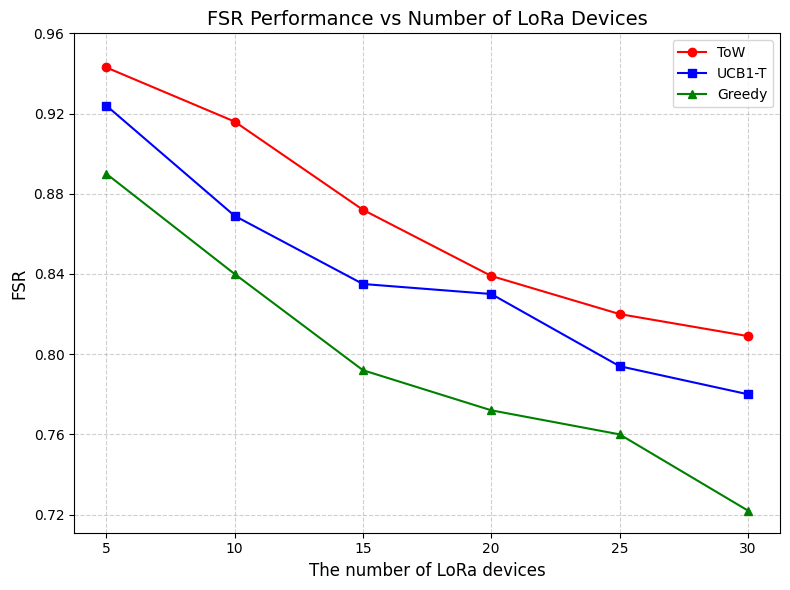

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Données simulées pour le FSR
lora_devices = [5, 10, 15, 20, 25, 30]  # Nombre de dispositifs LoRa
fsr_tow = [0.943, 0.916, 0.872, 0.839, 0.82, 0.809]  # FSR pour ToW
tfsr_ucb1 = [0.924, 0.869, 0.835, 0.830, 0.794, 0.78]  # FSR pour UCB1-T
fsr_greedy = [0.89, 0.84, 0.792, 0.772, 0.76, 0.722]  # FSR pour Greedy

# Création du graphique
plt.figure(figsize=(8, 6))
plt.plot(lora_devices, fsr_tow, marker='o', label='ToW', color='red')
plt.plot(lora_devices, tfsr_ucb1, marker='s', label='UCB1-T', color='blue')
plt.plot(lora_devices, fsr_greedy, marker='^', label='Greedy', color='green')

# Configuration des axes et du titre
plt.xlabel("The number of LoRa devices", fontsize=12)
plt.ylabel("FSR", fontsize=12)
plt.title("FSR Performance vs Number of LoRa Devices", fontsize=14)
plt.xticks(lora_devices, fontsize=10)
plt.yticks(np.linspace(0.72, 0.96, 7), fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Affichage du graphique
plt.tight_layout()
plt.show()


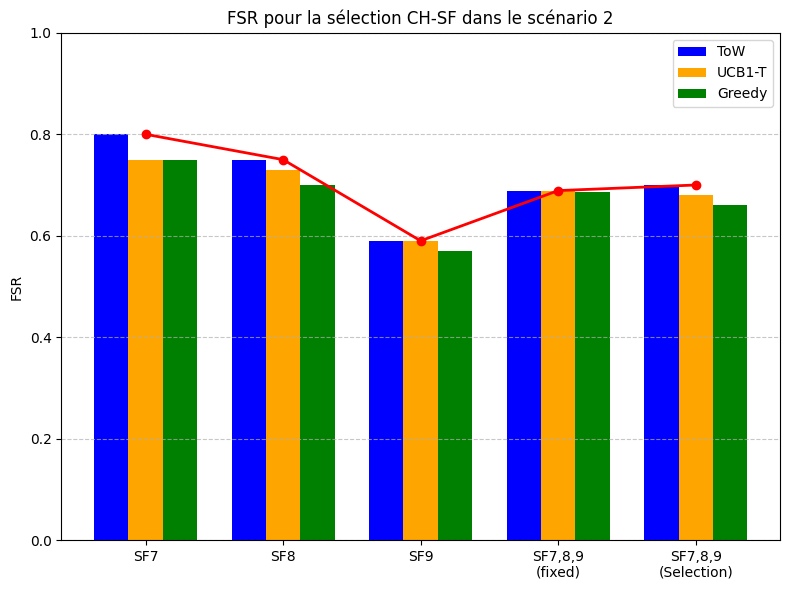

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Données pour le FSR dans la sélection CH-SF du scénario 2
categories = ['SF7', 'SF8', 'SF9', 'SF7,8,9\n(fixed)', 'SF7,8,9\n(Selection)']
tow = [0.8, 0.75, 0.59, 0.689, 0.7]  # Données ToW
ucb1_t = [0.75, 0.73, 0.59, 0.689, 0.68]  # Données UCB1-T
greedy = [0.75, 0.7, 0.57, 0.686, 0.66]  # Données Greedy

# Positions sur l'axe X
x = np.arange(len(categories))

# Largeur des barres
bar_width = 0.25

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 6))

# Barres pour chaque algorithme
ax.bar(x - bar_width, tow, width=bar_width, label='ToW', color='blue')
ax.bar(x, ucb1_t, width=bar_width, label='UCB1-T', color='orange')
ax.bar(x + bar_width, greedy, width=bar_width, label='Greedy', color='green')

# Ligne de connexion pour ToW
ax.plot(x, tow, color='red', marker='o', linewidth=2)

# Ajout des étiquettes, du titre et de la légende
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('FSR')
ax.set_ylim(0, 1)
ax.set_title('FSR pour la sélection CH-SF dans le scénario 2')
ax.legend()

# Ajout d'une grille
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.tight_layout()
plt.show()


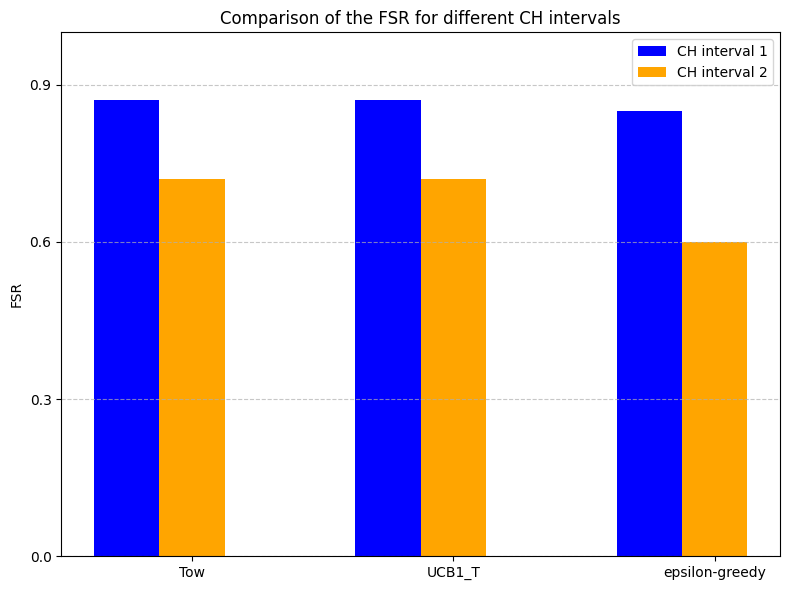

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Données pour le FSR dans la sélection CH-SF du scénario 2
categories = ['Tow', 'UCB1_T', 'epsilon-greedy']
CH_interval1 = [0.87, 0.87, 0.85]
CH_interval2 = [0.72, 0.72, 0.6]

# Positions sur l'axe X
x = np.arange(len(categories))

# Largeur des barres
bar_width = 0.25

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 6))

# Barres pour chaque algorithme
ax.bar(x - bar_width, CH_interval1, width=bar_width, label='CH interval 1', color='blue')
ax.bar(x, CH_interval2, width=bar_width, label='CH interval 2', color='orange')

# Ajout des étiquettes, du titre et de la légende
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('FSR')

# Configurer les limites et les graduations des ordonnées
ax.set_ylim(0, 1)  # Limites de 0 à 1
ax.set_yticks(np.arange(0, 1.1, 0.3))  # Intervalles de 0.3

ax.set_title('Comparison of the FSR for different CH intervals')
ax.legend()

# Ajout d'une grille
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.tight_layout()
plt.show()


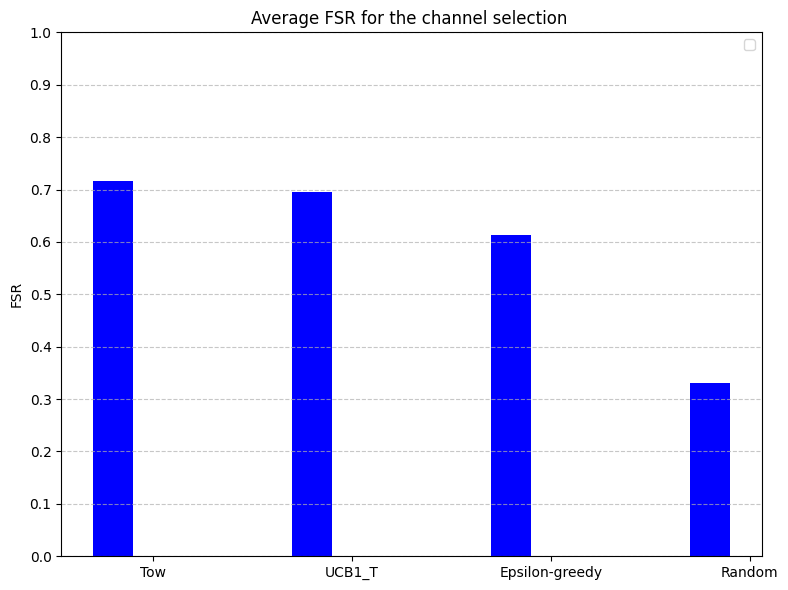

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Données pour le FSR dans la sélection CH-SF du scénario 2
categories = ['Tow', 'UCB1_T', 'Epsilon-greedy', 'Random']
CH_interval1 = [0.7155, 0.6948, 0.6128, 0.3306]


# Positions sur l'axe X
x = np.arange(len(categories))

# Largeur des barres
bar_width = 0.20

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 6))

# Barres pour chaque algorithme
ax.bar(x - bar_width, CH_interval1, width=bar_width, color='blue')


# Ajout des étiquettes, du titre et de la légende
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('FSR')

# Configurer les limites et les graduations des ordonnées
ax.set_ylim(0, 1)  # Limites de 0 à 1
ax.set_yticks(np.arange(0, 1.1, 0.1))  # Intervalles de 0.1

ax.set_title('Average FSR for the channel selection ')
ax.legend()

# Ajout d'une grille
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.tight_layout()
plt.show()
